#### Example running SpaFHy with jupyter notebook

In [1]:
from model_driver import driver
from iotools import read_results
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os

os.chdir(r'C:\SpaFHy_v1_Pallas_2D')

# example of calling driver, reading results
outputfile = driver(create_ncf=True, create_spinup=False, folder='testcase_input')
results = read_results(outputfile)

{1.0, 2.0, 3.0, 4.0} {1.0, 2.0, nan, 4.0}
*** State variables assigned from parameters.py ***
*** Distributed radiation used ***
*** Simulation forced with: testcase_input\forcing\Kenttarova_forcing_era5.csv


C:\SpaFHy_v1_Pallas_2D\canopygrid.py:798: RuntimeWarning: invalid value encountered in arccos
  dl = 2.0*np.arccos(cosZEN - np.sin(LAT)*np.sin(DECL) / (np.cos(LAT)*np.cos(DECL))) / CF / 15.0  # hours


*** Running model ***
*** 1D run
Running timestep:  1
Running timestep:  2
Running timestep:  3
Running timestep:  4
Running timestep:  5
Running timestep:  6
Running timestep:  7
Running timestep:  8
Running timestep:  9
Running timestep:  10
Running timestep:  11
Running timestep:  12
Running timestep:  13
Running timestep:  14
Running timestep:  15
Running timestep:  16
Running timestep:  17
Running timestep:  18
Running timestep:  19
Running timestep:  20
Running timestep:  21
Running timestep:  22
Running timestep:  23
Running timestep:  24
Running timestep:  25
Running timestep:  26
Running timestep:  27
Running timestep:  28
Running timestep:  29
Running timestep:  30
Running timestep:  31
Running timestep:  32
Running timestep:  33
Running timestep:  34
Running timestep:  35
Running timestep:  36
Running timestep:  37
Running timestep:  38
Running timestep:  39
Running timestep:  40
Running timestep:  41
Running timestep:  42
Running timestep:  43
Running timestep:  44
Running 

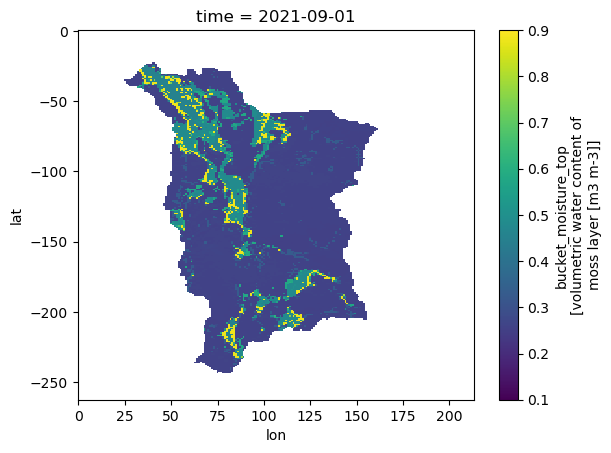

In [4]:
results['canopy']

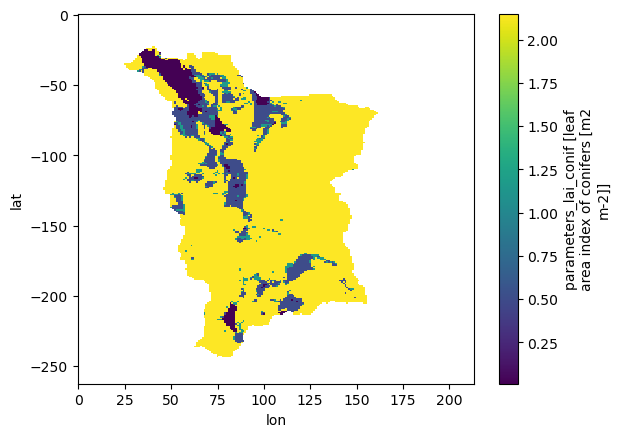

In [5]:
results['parameters_lai_conif'].plot()

In [1]:
xr.open_dataset(r'F:\SpaFHy_2D_2021\res_2d_ave_newnew_23.nc)['parameters_lai_conif'].plot()

SyntaxError: unterminated string literal (detected at line 1) (3974114339.py, line 1)